### This notebook was downloaded from [Roboflow](https://blog.roboflow.com/how-to-use-segment-anything-model-sam/).

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/danielcosta/Berkeley/207/Final_Project/SAM


## Install Segment Anything Model (SAM) and other dependencies

In [4]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# Note that we manually made a change to line 278 of segment_anything/automatic_mask_generator.py to work with mps
# Original: in_points = torch.as_tensor(transformed_points, device=self.predictor.device)
# Modified: in_points = torch.from_numpy(transformed_points.astype(np.float32)).to(self.predictor.device)
# GitHub Issue Credit: https://github.com/facebookresearch/segment-anything/issues/94
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

### Download SAM weights

In [3]:
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

^C


### Initialize SAM Checkpoint

In [5]:
CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/Users/danielcosta/Berkeley/207/Final_Project/SAM/weights/sam_vit_h_4b8939.pth ; exist: True


## Load Model

In [6]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import torch

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

/Users/danielcosta/GovTracker/local_news/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.loa

In [7]:
SAMPLE_IMAGE_PATH = os.path.join(HOME, "..", "Data", "Weather_Dataset", "glaze", "6710.jpg")
os.path.isfile(SAMPLE_IMAGE_PATH)

True

## Automated Mask Generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [5]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [8]:
from datetime import datetime, timedelta
from IPython.display import display, HTML, clear_output
import time
from tqdm.notebook import tqdm

def sam_progress(start_time, i, n, filename, output_display):   
    elapsed_time = datetime.now() - start_time
    estimated_total_time = elapsed_time / (i + 1) * n
    remaining_time = estimated_total_time - elapsed_time
    progress_str = f"""Processing {i+1}/{n}: {filename}
    {100*(i+1)/n:.2f}% done
    Started at: {start_time}
    Elapsed time: {elapsed_time}
    Estimated remaining time: {remaining_time}
    Estimated total time: {estimated_total_time}
    ETA: {start_time + estimated_total_time}
    Average time per image: {elapsed_time / (i + 1)}
    """
    clear_output(wait=True)
    output_display.update(HTML(f"<pre>{progress_str}</pre>")) 

    

In [19]:
import sys
#!pip show torch # old torch==2.6.0
!{sys.executable} -m pip install fastsam --force-reinstall

  Using cached fastsam-0.0.1.dev0-py3-none-any.whl.metadata (374 bytes)
  Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached fastsam-0.0.1.dev0-py3-none-any.whl (1.1 kB)
Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl (66.5 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using cached 

In [24]:
import sys
import torch
print(torch.__version__)
!{sys.executable} -m pip install fastsam --force-reinstall

2.5.1
  Using cached fastsam-0.0.1.dev0-py3-none-any.whl.metadata (374 bytes)
  Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl.metadata (28 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (4.0 kB)
Using cached fastsam-0.0.1.dev0-py3-none-any.whl (1.1 kB)
Using cached torch-2.6.0-cp311-none-macosx_11_0_arm64.whl (66.5 MB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
Using cached filelock-3.18.0-py3-none-any.whl (16 kB)
Using c

In [23]:
from fastsam import FastSAM, FastSAMPrompt

model = FastSAM("FastSAM-x.pt", device=DEVICE)

ModuleNotFoundError: No module named 'fastsam'

### Generate masks with SAM

In [10]:
import cv2
import supervision as sv

torch.set_default_dtype(torch.float32)

image_bgr = cv2.imread(SAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image_rgb = cv2.resize(image_rgb, (224, 224))

sam_result = mask_generator.generate(image_rgb)

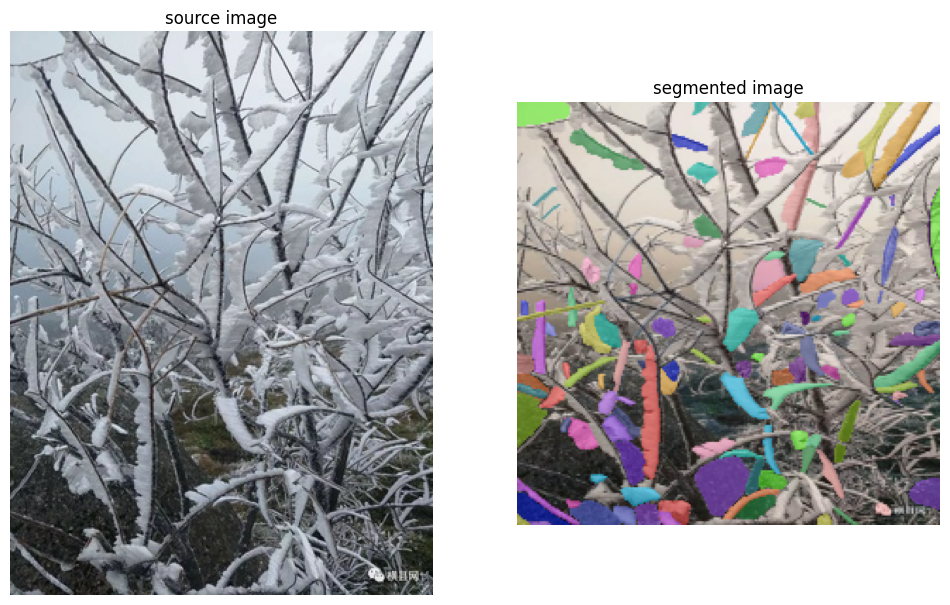

In [12]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_rgb.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [11]:

def segment_image(dirpath, image_filepath, mask_generator):
    image_bgr = cv2.imread(os.path.join(dirpath, image_filepath))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    sam_result = mask_generator.generate(image_rgb)
    return image_bgr, sam_result

def annotate_image(image_bgr, sam_result):
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
    detections = sv.Detections.from_sam(sam_result=sam_result)
    annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
    return annotated_image

def serialize_sam_result(sam_result):
    for mask in sam_result:
        mask['segmentation'] = mask['segmentation'].tolist()
    return {
        "masks": sam_result
    }

In [36]:
IMAGE_DATA_PATH = os.path.join(HOME, "..", "Data", "Weather_Dataset")
SEGMENTED_IMAGES_DIR = os.path.join(IMAGE_DATA_PATH, "..", "Segmented_Images")
MASKS_DIR = os.path.join(IMAGE_DATA_PATH, "..", "Image_Masks")
!mkdir -p {SEGMENTED_IMAGES_DIR}
!mkdir -p {MASKS_DIR}

python(61234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(61235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [37]:
n_files = 0
for dirpath, class_dirnames, filenames in os.walk(IMAGE_DATA_PATH):
    for class_dirnames in class_dirnames:
        for dirpath_class, _, filenames_class in os.walk(os.path.join(dirpath, class_dirnames)):
            filenames_class = [filename for filename in filenames_class if filename.endswith(".jpg")]
            n_files += len(filenames_class)
print(f"Number of image files: {n_files}")

Number of image files: 6604


In [31]:
# Try saving the images and JSON files to their respective folders
# Get list of directories from Weather Dataset
import json


# TODO: If directory exists, skip
# TODO: If file has already been processed, skip

output_display = display(HTML(""), display_id=True)
i = 0
n = n_files
start_time = datetime.now()
for dirpath, class_dirnames, filenames in os.walk(IMAGE_DATA_PATH):
    for class_dirname in class_dirnames:
        # Create directory for each class in Segmented_Images and Image_Masks
        class_segment_dirpath = os.path.join(SEGMENTED_IMAGES_DIR, class_dirname)
        class_mask_dirpath = os.path.join(MASKS_DIR, class_dirname)
        if not os.path.exists(class_segment_dirpath):
            !mkdir -p {class_segment_dirpath}
        if not os.path.exists(class_mask_dirpath):
            !mkdir -p {class_mask_dirpath}
        for dirpath_class, _, filenames_class in os.walk(os.path.join(dirpath, class_dirname)):
            for filename in filenames_class:
                
                segmented_image_path = os.path.join(class_segment_dirpath, f"{filename[:-4]}.jpg")
                image_mask_path = os.path.join(class_mask_dirpath, f"{filename[:-4]}.json")


                if os.path.isfile(segmented_image_path) and os.path.isfile(image_mask_path):
                    sam_progress(start_time, i, n, "skipped", output_display)
                    i += 1
                    continue

                if filename.endswith(".jpg"):
                    # Create segmentation and mask
                    image_filepath = os.path.join(dirpath_class, filename)
                    image_bgr, sam_result = segment_image(dirpath_class, image_filepath, mask_generator)
                    annotated_image = annotate_image(image_bgr, sam_result)
                    # Save the images and JSON files
                    filename = os.path.splitext(filename)[0]
                    
                    cv2.imwrite(segmented_image_path, annotated_image)
                    with open(image_mask_path, 'w') as f:
                        serialized_sam_result = serialize_sam_result(sam_result)
                        json.dump(serialized_sam_result, f, separators=(',', ':'))
                    sam_progress(start_time, i, n, segmented_image_path, output_display)
                    i += 1
# Pick the first file from each
# Create their images and JSON files
# Save them to their respective folders in Data/Segmented_Images and Data/Image_Masks

### Output format

`SamAutomaticMaskGenerator` returns a `list` of masks, where each mask is a `dict` containing various information about the mask:

* `segmentation` - `[np.ndarray]` - the mask with `(W, H)` shape, and `bool` type
* `area` - `[int]` - the area of the mask in pixels
* `bbox` - `[List[int]]` - the boundary box of the mask in `xywh` format
* `predicted_iou` - `[float]` - the model's own prediction for the quality of the mask
* `point_coords` - `[List[List[float]]]` - the sampled input point that generated this mask
* `stability_score` - `[float]` - an additional measure of mask quality
* `crop_box` - `List[int]` - the crop of the image used to generate this mask in `xywh` format

In [74]:
import json
sam_result[0]['segmentation'] = sam_result[0]['segmentation'].tolist()
with open('sam_result_0_test.json', 'w') as f:
    json.dump(sam_result[0], f, indent=4)

### Results visualisation with Supervision

As of version `0.5.0` Supervision has native support for SAM.

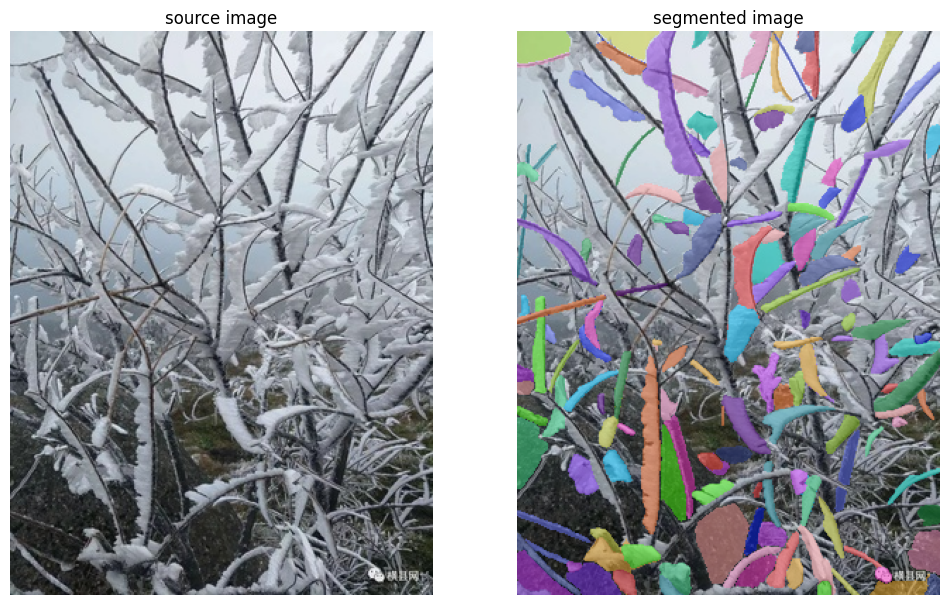

In [47]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

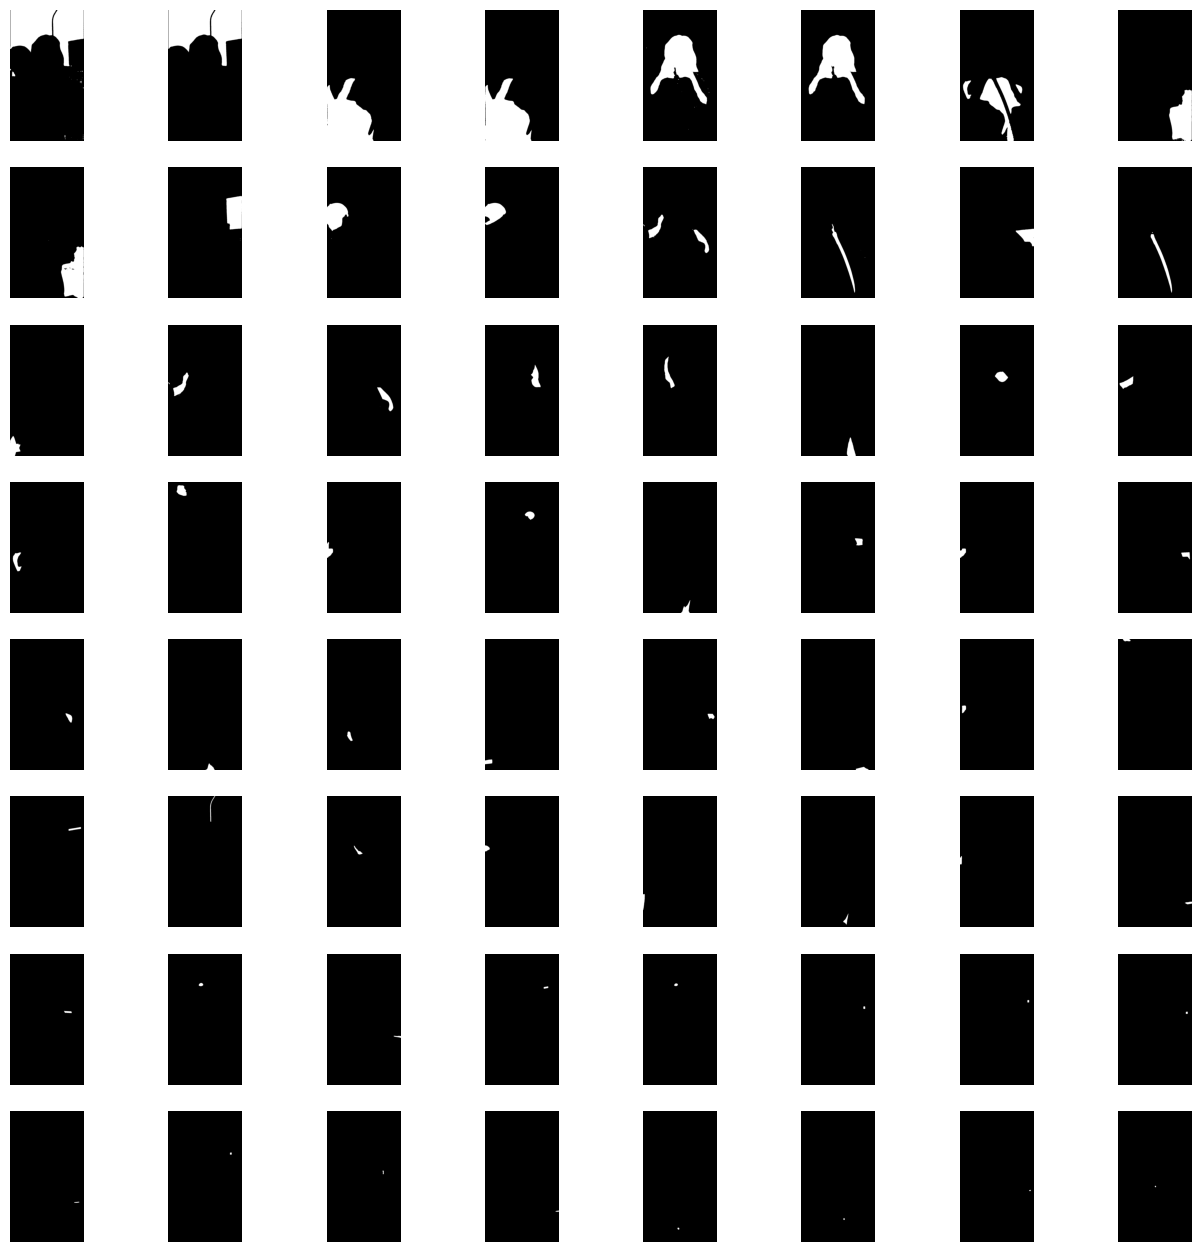

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

## Generate Segmentation with Bounding Box

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [ ]:
mask_predictor = SamPredictor(sam)

In [ ]:


IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data", IMAGE_NAME)

### Draw Box



In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 69, 'y': 246, 'width': 555, 'height': 684, 'label': ''}]

### Generate masks with SAM

**NOTE:** `SamPredictor.predict` method takes `np.ndarray` `box` argument in `[x_min, y_min, x_max, y_max]` format. Let's reorganise your data first

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

### Results visualisation with Supervision

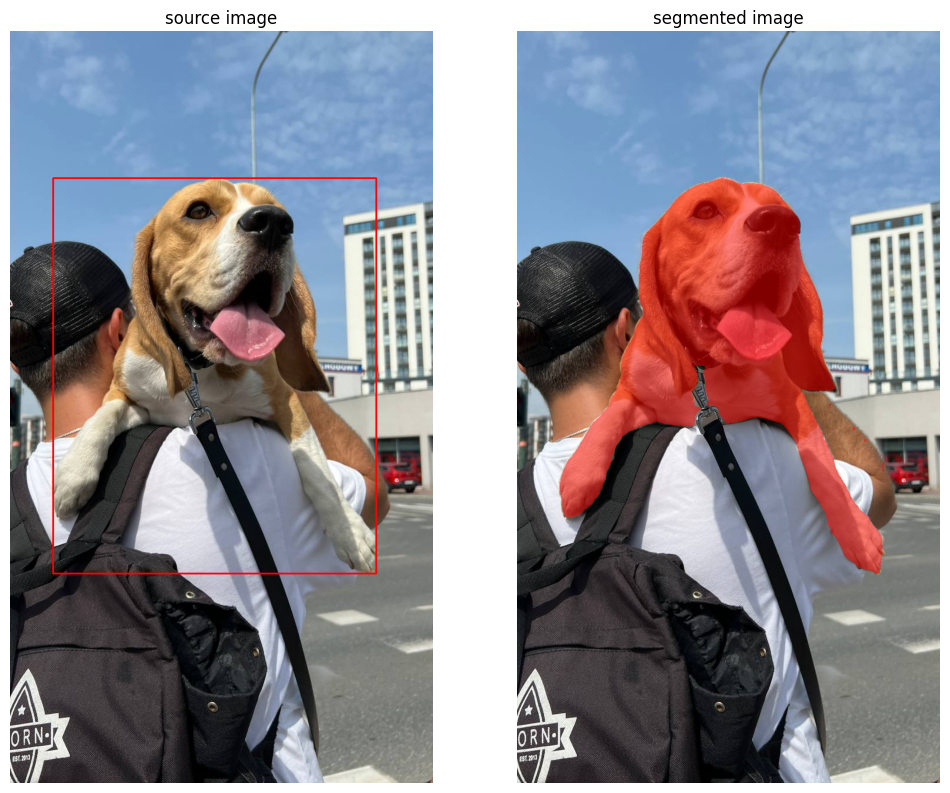

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

### Interaction with segmentation results

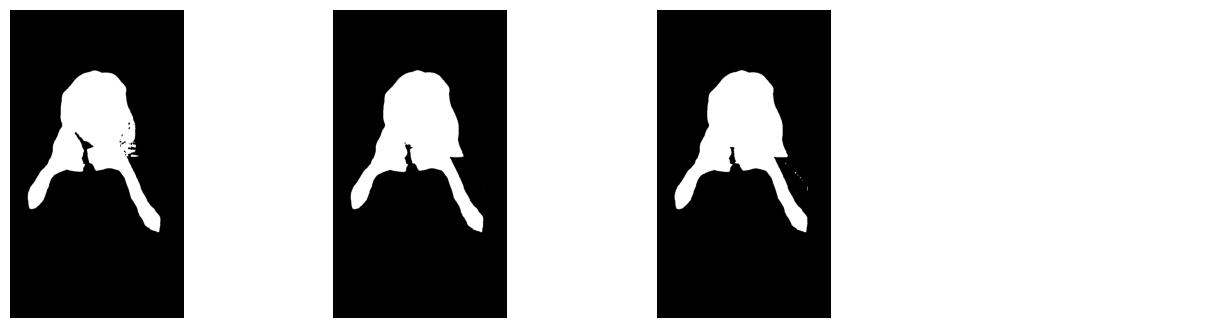

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

## Segment Anything in Roboflow Universe Dataset

### Utils Supporting Dataset Processing

A couple of helper functions that, unfortunately, we have to write ourselves to facilitate the processing of COCO annotations.

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )

### Download Dataset from Roboflow

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("hashira-fhxpj").project("mri-brain-tumor")
dataset = project.version(1).download("coco")

In [ ]:


DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

['YES-TUMOR']

### Single Image Bounding Box to Mask

In [ ]:
# set random seed to allow easy reproduction of the experiment

import random
random.seed(10)

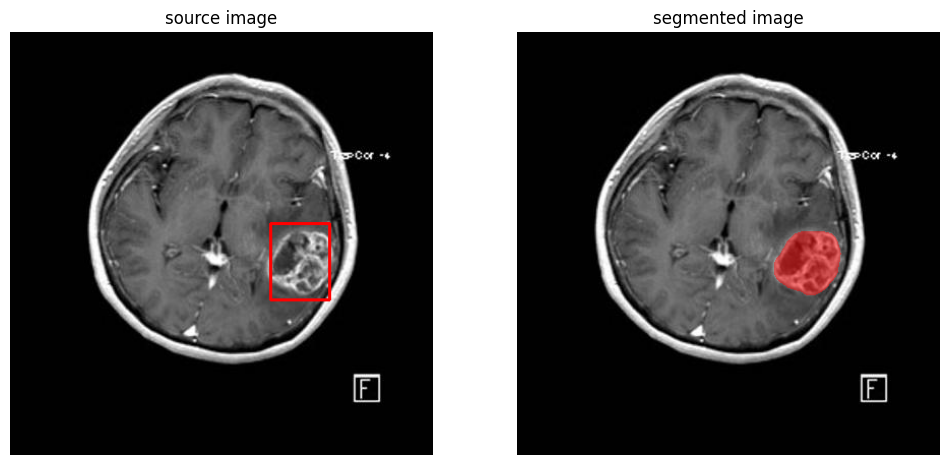

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.